In [81]:
from src.utils.results_utils import *
from src.utils.data_utils import str_dict_to_values

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


## Loading the cleaned and conditionned dataset 

In [82]:
df_char_cleaned = pd.read_csv('data/cleaned.csv')

## Genre Analysis

In [83]:
#Let's make a list of the genres we are interested in and assign one of them to each character
genres_list = ['Action & Adventure', 'Drama', 'Comedy', 'Horror & Thriller', 
              'Fantasy & Sci-Fi', 'Historical & War', 'Romance', 'Documentary', 
              'Music & Performance', 'Cult & B-Movies', 'Other']
df_char_cleaned['Genre_Category'] = df_char_cleaned['Genres'].apply(lambda x: categorize_genre(x))

In [84]:
#Let's see the most frequent names in each genre and for each gender
frequent_names_m, frequent_names_f = get_top_names_by_genre(df_char_cleaned)

In [85]:
frequent_names_f.head(5)

,Action & Adventure,Drama,Comedy,Horror & Thriller,Fantasy & Sci-Fi,Historical & War,Romance,Documentary,Music & Performance,Cult & B-Movies,Other
0,None,None,None,None,None,None,None,None,None,None,Sarah
1,None,None,None,None,None,None,None,None,None,None,Alice
2,None,None,None,None,None,None,None,None,None,None,Helen
3,None,None,None,None,None,None,None,None,None,None,Susan
4,None,None,None,None,None,None,None,None,None,None,Kate


In [86]:
frequent_names_m.head(5)

,Action & Adventure,Drama,Comedy,Horror & Thriller,Fantasy & Sci-Fi,Historical & War,Romance,Documentary,Music & Performance,Cult & B-Movies,Other
0,None,None,None,None,None,None,None,None,None,None,John
1,None,None,None,None,None,None,None,None,None,None,George
2,None,None,None,None,None,None,None,None,None,None,Tom
3,None,None,None,None,None,None,None,None,None,None,David
4,None,None,None,None,None,None,None,None,None,None,Paul


In [87]:
#Now, let's see the number of appearences of each name in our dataset, and in which genres they appear
genre_counts_result, movies_with_name = count_name_appearance_by_genre(df_char_cleaned, genres_list, 'Leo')
print(genre_counts_result.head())
movies_with_name.head(10)

   Action & Adventure  Drama  Comedy  Horror & Thriller  Fantasy & Sci-Fi  \
0                   0      0       0                  0                 0   

   Historical & War  Romance  Documentary  Music & Performance  \
0                 0        0            0                    0   

   Cult & B-Movies  Other  
0                0    120  


,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Genre_Category
466,21271533,Bleeder,['Danish Language'],['Denmark'],"['Thriller', 'Drama']",Leo,M,34.0,[Other]
487,17379289,Without Warning,['English Language'],['United States of America'],"['Science Fiction', 'Horror']",Leo,M,60.0,[Other]
2026,13934307,Mammoth,"['Tagalog language', 'English Language', 'Thai...","['Denmark', 'Sweden', 'Germany']","['Drama', 'Indie', 'World cinema']",Leo,M,30.0,[Other]
5098,277710,Heartbreakers,"['Russian Language', 'English Language']",['United States of America'],"['Crime Fiction', 'Romantic comedy', 'Romance ...",Leo,M,45.0,[Other]
5962,21845518,Seis días en la oscuridad,['Spanish Language'],['Mexico'],"['Thriller', 'Crime Fiction', 'Drama']",Leo,M,NaN,[Other]
7254,26717073,Unknown,"['Arabic Language', 'German Language', 'Englis...","['United States of America', 'Canada', 'France...","['Thriller', 'Mystery', 'Action', 'Drama', 'Ps...",Leo,M,48.0,[Other]
8220,2728447,Bedrooms and Hallways,['English Language'],['United Kingdom'],"['LGBT', 'Romantic drama', 'Romance Film', 'Dr...",Leo,M,NaN,[Other]
8295,648921,Face/Off,"['Latin Language', 'English Language']",['United States of America'],"['Thriller', 'Crime Fiction', 'Tragedy', 'Chas...",Leo,M,31.0,[Other]
8720,22574577,Milarepa,['Italian Language'],['Italy'],['Drama'],Leo,M,27.0,[Other]
8864,13814165,Meet the Spartans,['English Language'],"['United States of America', 'Canada']","['Parody', 'Period piece', 'Sword and Sandal',...",Leo,M,NaN,[Other]


## Gender Analysis

In [88]:
df_vowels, df_consonants = get_vowel_stats(df_char_cleaned)

print('Stats for vowels in character names by sex:')
print(df_vowels)

print('Stats for consonants in character names by sex:')
print(df_consonants)

Stats for vowels in character names by sex:
         mean       std
Sex                    
F    2.712791  0.819139
M    2.408568  0.890082
Stats for consonants in character names by sex:
         mean       std
Sex                    
F    3.348056  1.253225
M    3.669876  1.356432


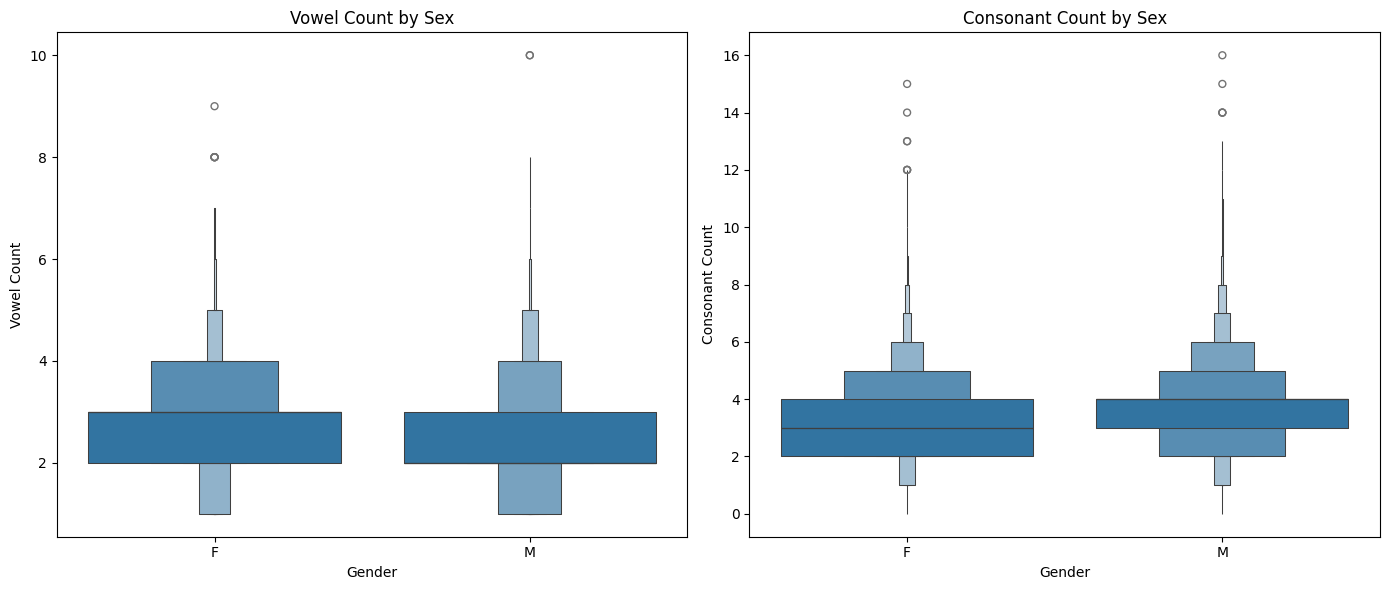

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Sex')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Sex')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Consonant Count')

plt.tight_layout()

In [90]:
df_length = get_length_stats(df_char_cleaned)

print('Length stats for character names by sex:')
print(df_length)

Length stats for character names by sex:
         mean       std
Sex                    
F    6.060847  1.653263
M    6.078445  1.849723


In [91]:
df_percent_vowel = get_vowel_percentage(df_char_cleaned)

print('Vowel percentage stats for character names by sex:')
print(df_percent_vowel)

Vowel percentage stats for character names by sex:
         mean       std
Sex                    
F    0.455334  0.107061
M    0.401031  0.107929


In [92]:
first_letter_counts = create_letter_count_df(df_char_cleaned,0)
last_letter_counts = create_letter_count_df(df_char_cleaned,-1)

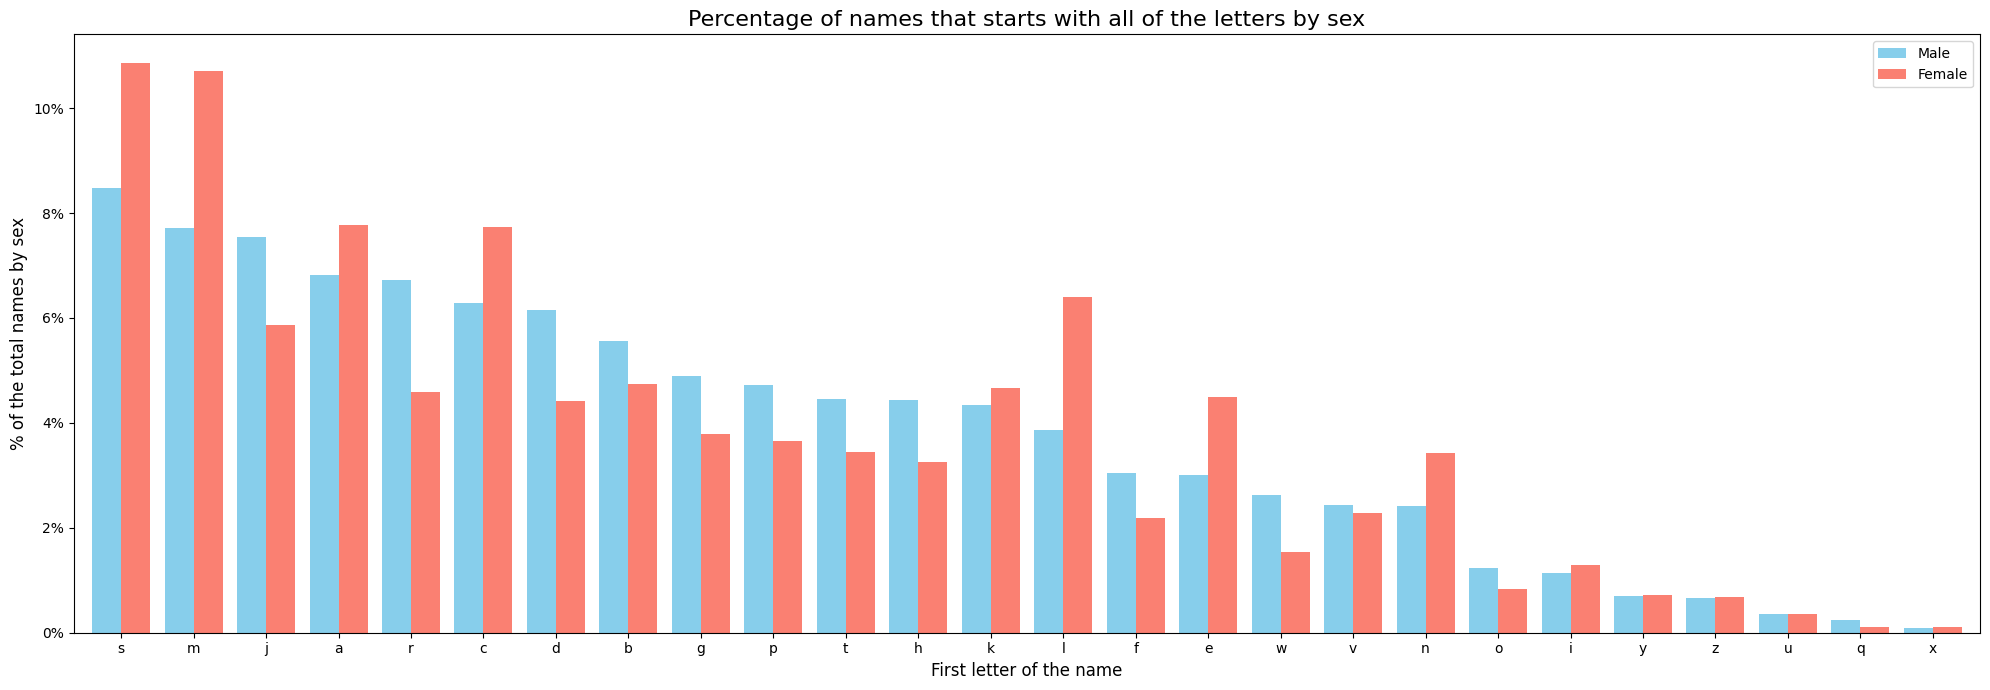

In [93]:
fig, ax = plt.subplots(figsize=(20, 7))

first_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Percentage of names that starts with all of the letters by sex', fontsize=16)
ax.set_xlabel('First letter of the name', fontsize=12)
ax.set_ylabel('% of the total names by sex', fontsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

ax.legend(['Male', 'Female'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

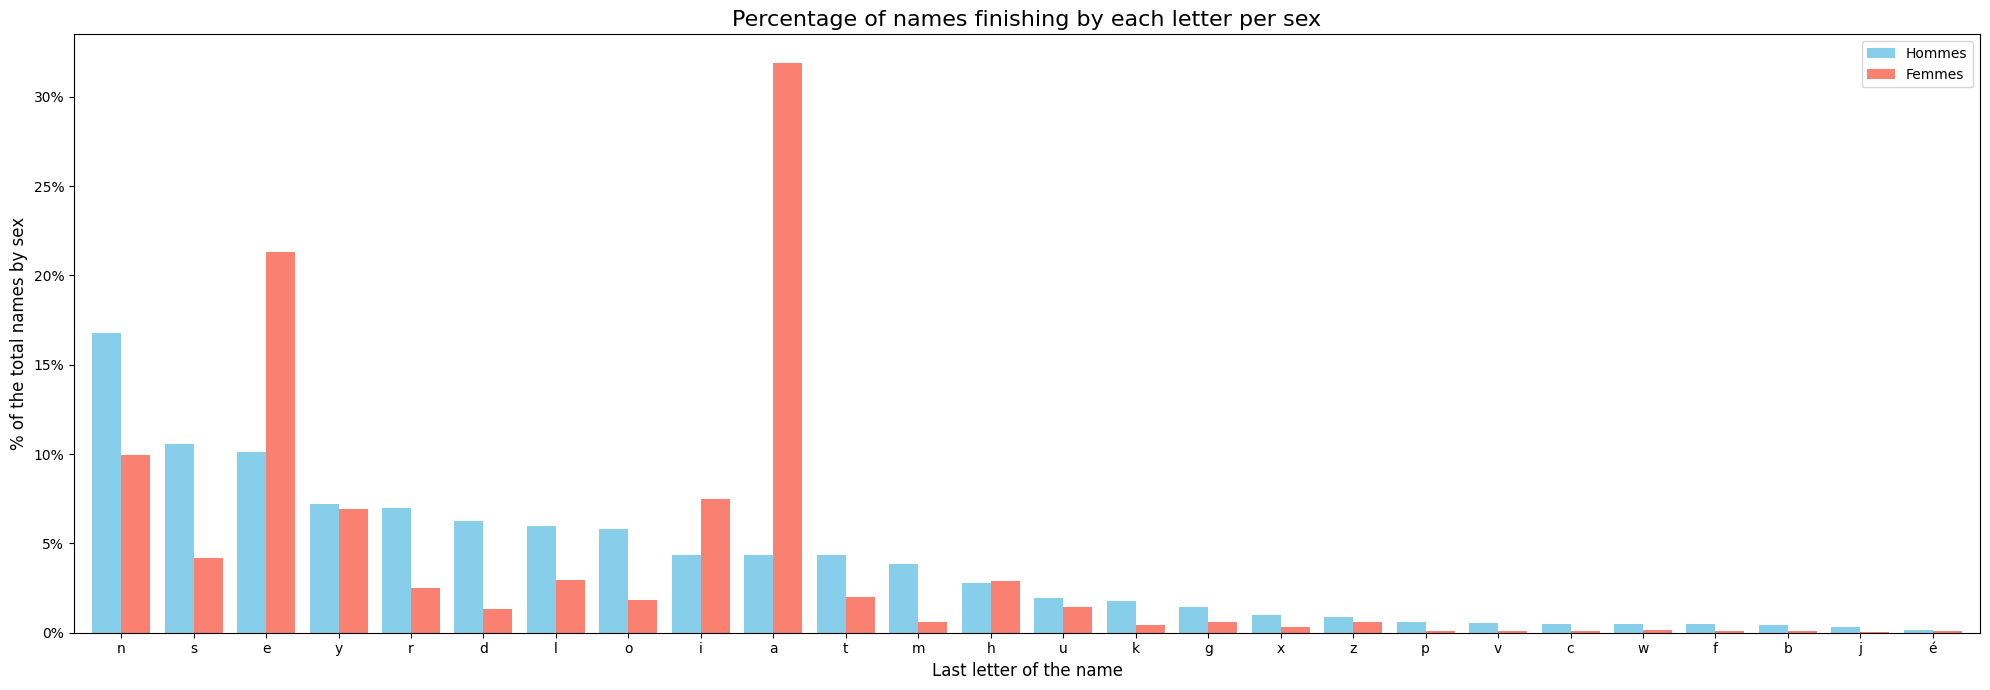

In [94]:
fig, ax = plt.subplots(figsize=(20, 7))

last_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Percentage of names finishing by each letter per sex', fontsize=16)
ax.set_xlabel('Last letter of the name', fontsize=12)
ax.set_ylabel('% of the total names by sex', fontsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

ax.legend(['Hommes', 'Femmes'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [95]:
age_sex_percentage, age_labels = get_age_sex_percentage(df_char_cleaned)

top_names = (
    df_char_cleaned.groupby(['age_category', 'Sex'])['Character_name']
    .apply(lambda x: x.value_counts().head(3).index.tolist())
    .unstack(fill_value=[])
)

/Users/luca/Desktop/ada-2024-project-adadasurmonbidet2024/src/utils/results_utils.py:178: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_63744/1270236452.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [96]:
fig = go.Figure()

for sex in ['M', 'F']:
    fig.add_trace(go.Bar(
        x=age_labels,
        y=age_sex_percentage[sex],
        name='Male' if sex == 'M' else 'Female',
        marker_color='skyblue' if sex == 'M' else 'salmon',
        hovertext=[f"Top names: {', '.join(top_names.loc[age, sex])}" for age in age_labels],
        hoverinfo="text"
    ))

fig.update_layout(
    title='Percentage of Males and Females in Each Age Category',
    xaxis_title='Age Category',
    yaxis_title='% of Total Males/Females',
    barmode='group',
    xaxis=dict(tickvals=age_labels, tickangle=0),
    yaxis=dict(ticksuffix='%'),
    legend=dict(title="Sex")
)

fig.show()

## Country Analysis

In [97]:
countries_code = []

df_continent = create_continent_df(df_char_cleaned,countries_code)
print(df_continent)

TypeError: create_continent_df() takes 1 positional argument but 2 were given

In this table we see the most recurrent character names for each continent. For Asia, we see that the most common names are indian names. Is it because other nearby countries are influenced by the bollywood industry or because India's movies are predominent in this dataset? 
We will try to answer the question by plotting the most common character names per country and reting it with the number of movies from this country in the dataset.

In [ ]:
df_top_names = create_top_names_df(df_char_cleaned)
df_nb_movies = create_nb_movie_df(df_char_cleaned)

In [ ]:
df_map_names = pd.merge(df_nb_movies,df_top_names,on='primary_country',how='inner')

In [ ]:
fig = go.Figure(go.Scattergeo(
))
fig.add_trace(go.Choropleth(
    locations= df_map_names['primary_country'],
    locationmode='country names',
    showscale= True,
    colorscale='YlOrRd',
    z=np.log10(df_map_names['Number_of_movies']),
    colorbar=dict(title="Number of movies (Log Scale)", tickvals=np.arange(0, 5), ticktext=[f"10^{i}" for i in range(0, 5)]),
    text= [f"Top female name: {female}<br>Top male name: {male}<br>Movies: {movies:,}" 
           for female, male, movies in zip(df_map_names['Female_name'], df_map_names['Male_name'], df_map_names['Number_of_movies'])],
    hovertemplate="%{location}<br>%{text}"
))
fig.update_geos(
    projection_scale=1,center={'lat': 30},
    visible=False,
    showcountries=True, countrycolor="RebeccaPurple"
)
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        lakecolor="aqua"
    ),
    height=500,
    margin={"r":0,"t":5,"l":0,"b":0},
    title="Most Common Male and Female Names by Continent"
)
fig.show()

## Ngram Analysis

In [ ]:
df_ngram = create_ngram(df_char_cleaned)
kmeans_clustering(df_ngram,df_char_cleaned)
pca_result,loading = ipca_reduction(df_ngram)

In [ ]:
country_df = create_continent_df(df_char_cleaned)

In [ ]:
palette = ['#de324c','#f4895f','#f8e16f','#95cf92','#369acc','#9656a2']
fig,axs = plt.subplots(1,3,figsize=(18, 6))
fig.suptitle("PCA of Character N-grams in Names by Continent", fontsize=16)

sns.scatterplot(x="pca_one", y="pca_two", hue="continent", data=country_df, palette=palette, size=2,linewidth=0.3, ax=axs[0])
sns.scatterplot(x="pca_one", y="pca_three", hue="continent", data=country_df, palette=palette, size=2,linewidth=0.3, ax=axs[1])
sns.scatterplot(x="pca_two", y="pca_three", hue="continent", data=country_df, palette=palette, size=2,linewidth=0.3, ax=axs[2])
plt.title("PCA of Character N-grams in Names by Continent")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
